In [1]:
import json
import sys
import copy

In [2]:
business_file = open('yelp_dataset/yelp_academic_dataset_business.json')

categories = ['Beauty & Spas','Shopping','Bars']
categories_list = categories.copy()
categories = set(categories)
filtered_business = {}
filtered_business_categories = {}

for line in business_file:
    business = json.loads(line)
    if business['city'] == 'Toronto' and int(business['review_count']) >= 10:
        business_categories = business['categories']
        filtered_business_categories[business['business_id']] = business['categories']
        if business_categories is not None:
            business_categories = business_categories.split(',')
            business_categories = set(business_categories)
            if len(categories.intersection(business_categories)) > 0:
                common_elements = categories.intersection(business_categories)
                common_elements = list(common_elements)
                if categories_list[0] in common_elements:
                    filtered_business[business['business_id']] = categories_list[0]
                elif categories_list[1] in common_elements:
                    filtered_business[business['business_id']] = categories_list[1]
                elif categories_list[2] in common_elements:
                    filtered_business[business['business_id']] = categories_list[2]
print(len(filtered_business))
business_file.close()

749


In [3]:
reviews_file = open('yelp_dataset/yelp_academic_dataset_review.json')
reviews = {}
for line in reviews_file:
    review = json.loads(line)
    if review['business_id'] in filtered_business.keys():
        value = reviews.get(review['business_id'])
        if value is None :
            reviews[review['business_id']] = review['text']
        else:
            reviews[review['business_id']] += ' ' + review['text']
reviews_file.close()

In [4]:
reviews_list = []
for key, value in reviews.items():
    temp = [key,value,filtered_business[key],filtered_business_categories[key]]
    reviews_list.append(temp)
print(len(reviews_list))

749


In [5]:
review_ids,corpus,target,full_list_of_categories = zip(*reviews_list)

In [6]:
true_labels = []
for idx,item in enumerate(target):
    if item == 'Shopping':
        true_labels.append(0)
    elif item == 'Bars':
        true_labels.append(1)
    elif item == 'Beauty & Spas':
        true_labels.append(2)

In [7]:
import sklearn.feature_extraction.text as sk_text

In [8]:
vectorizer = sk_text.TfidfVectorizer(min_df=1,stop_words = 'english',max_features=1000) #min_df = 0.05
X = vectorizer.fit_transform(corpus)
print(X.toarray())
print(X.get_shape)

[[0.00658072 0.02450147 0.00404368 ... 0.         0.00560579 0.01470713]
 [0.         0.         0.         ... 0.         0.00651807 0.00855028]
 [0.00494784 0.01210582 0.01135053 ... 0.00129321 0.         0.        ]
 ...
 [0.02787523 0.01482652 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.03989281 ... 0.         0.         0.        ]]
<bound method spmatrix.get_shape of <749x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 282220 stored elements in Compressed Sparse Row format>>


In [9]:
#print (vectorizer.get_feature_names())

In [10]:
import sklearn.cluster as sk_cluster

In [11]:
def categories_statistics(predictions,reviews_list,filtered_business_categories):
    idxArray = np.where(predictions == 2)
    for index in idxArray:
        #business_id = reviews_list[idxArray[0][1]][0]
        business_id = reviews_list[index][0]
        print(filtered_business_categories[business_id])
#print(reviews_list[idxArray[0][1]][1])
#print(np.where(predictions == 2))

In [12]:
from sklearn import metrics
import numpy as np
import scipy.spatial.distance as sp_dist

In [13]:
def scores(true_labels,mapped_kmeans_labels):    
    p = metrics.precision_score(true_labels,mapped_kmeans_labels, average=None)
    print(p)
    r = metrics.recall_score(true_labels,mapped_kmeans_labels, average = None)
    print(r)
    p = metrics.precision_score(true_labels,mapped_kmeans_labels, average='weighted')
    print(p)
    r = metrics.recall_score(true_labels,mapped_kmeans_labels, average = 'weighted')
    print(r)

In [14]:
def cluster_class_mapping(kmeans_labels,true_labels):
    C= metrics.confusion_matrix(kmeans_labels,true_labels)
    mapping = list(np.argmax(C,axis=1)) #for each row (cluster) find the best class in the confusion matrix
    mapped_kmeans_labels = [mapping[l] for l in kmeans_labels]
    C2= metrics.confusion_matrix(mapped_kmeans_labels,true_labels)
    return mapped_kmeans_labels,C2

In [15]:
def center_distances(kmeans):
    D = sp_dist.pdist(kmeans.cluster_centers_, 'euclidean') 
    distances_array = sp_dist.squareform(D)
    return sp_dist.squareform(D)

### Kmeans για Κ=3

In [16]:
k=3
kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=k, n_init=10)
kmeans.fit_predict(X)

array([1, 1, 2, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0, 1, 1, 0,
       2, 2, 2, 2, 0, 2, 0, 1, 2, 0, 2, 0, 1, 2, 2, 0, 1, 0, 0, 0, 2, 2,
       1, 2, 2, 0, 1, 1, 0, 0, 2, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 1,
       1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 0, 1, 0, 0, 2, 1, 0, 1, 2, 1, 0, 0,
       0, 0, 0, 2, 0, 2, 1, 2, 2, 0, 2, 0, 0, 1, 0, 1, 2, 1, 0, 2, 1, 0,
       0, 1, 0, 0, 2, 0, 2, 2, 2, 0, 1, 1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0,
       1, 2, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 0, 0, 2, 0, 1,
       1, 1, 2, 2, 0, 0, 1, 0, 1, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2,
       0, 0, 0, 1, 2, 2, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 2, 0, 1, 0, 0, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       2, 2, 0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0,

In [17]:
mapped_kmeans_labels,C = cluster_class_mapping(kmeans.labels_,true_labels)
print(C)
scores(true_labels,mapped_kmeans_labels)
print(center_distances(kmeans))

[[246   3  73]
 [  7 241   1]
 [  8   1 169]]
[0.76397516 0.96787149 0.9494382 ]
[0.94252874 0.98367347 0.69547325]
0.8908404709349034
0.8758344459279038
[[0.         0.57412343 0.59996866]
 [0.57412343 0.         0.76125727]
 [0.59996866 0.76125727 0.        ]]


### Επιχειρήσεις που πήγαν λάθος Lookup στις κατηγορίες και στα top-terms της κάθε επιχείρησης
* Βάση του lookup κανείς μπορεί να δει ότι top-terms των επιχειρήσεων αυτών είναι service,staff,people,store,girls,product,place,loaction που είναι λέξεις που συναντά κανείς σε σχολιασμό επιχειρήσεων που ανήκουν στην κατηγορία shopping

In [18]:
true_labels_np = np.array(true_labels)
idx_true = np.where(true_labels_np == 2)
predicted_labels_np = np.array(mapped_kmeans_labels)
idx_predicted = np.where(predicted_labels_np == 0)
intersection = np.intersect1d(idx_true, idx_predicted)
print(len(intersection))
counter = []
for item in intersection:
    values = full_list_of_categories[item].split(',')
    for value in values:
        counter.append(value)
print(set(counter))
for business in intersection[:20]:
    asc_order_business = X[business].toarray().argsort()
    order_business = asc_order_business[0][::-1]
    print(reviews_list[business][3])
    terms = vectorizer.get_feature_names()
    for ind in order_business[:10]:
        print (' %s' % terms[ind])

73
{' Adult Entertainment', ' Art Galleries', ' Hotels', ' Traditional Chinese Medicine', ' Hair Removal', ' Pubs', ' Waxing', ' Specialty Schools', ' Dentists', ' Cosmetics & Beauty Supply', ' Local Flavor', ' Day Spas', ' Restaurants', ' Skin Care', ' Cosmetology Schools', ' British', ' Bars', ' Nail Salons', ' Tanning', 'Beauty & Spas', ' Makeup Artists', ' Massage', ' Piercing', ' Laser Hair Removal', ' Float Spa', ' Medical Centers', ' Lounges', ' Bridal', ' Hair Salons', ' Foot Care', ' Osteopathic Physicians', ' Hair Extensions', ' Hotels & Travel', ' Event Planning & Services', ' Local Services', ' Medical Spas', ' Active Life', ' Education', ' Doctors', ' Threading Services', ' Comfort Food', ' Eyebrow Services', ' Health & Medical', ' Yoga', ' Permanent Makeup', ' Eyelash Service', ' Spiritual Shop', ' Massage Therapy', ' Fitness & Instruction', ' Arts & Entertainment', ' Drugstores', ' Tattoo', ' Chiropractors', ' Reiki', ' Shopping', ' Jewelry', ' Physical Therapy', ' Night

### Κορυφαία terms ανά cluster για το clustering με Κ=3 Κέντρα

In [19]:
print("Top terms per cluster:")
asc_order_centroids = kmeans.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(k):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 store
 like
 place
 service
 time
 just
 great
 staff
 good
 customer
Cluster 1:
 food
 bar
 place
 good
 drinks
 great
 beer
 menu
 night
 like
Cluster 2:
 hair
 nails
 cut
 salon
 nail
 haircut
 shellac
 place
 time
 barber


In [20]:
def agglomerative(X,true_labels,linkage):
    print(str.upper(linkage))
    agglo = sk_cluster.AgglomerativeClustering(linkage=linkage, n_clusters = 3)
    agglo_labels = agglo.fit_predict(X.toarray())
    C_agglo= metrics.confusion_matrix(agglo_labels,true_labels)
    mapped_agglo_labels,C_agglo = cluster_class_mapping(agglo_labels,true_labels)
    print(C_agglo)
    p = metrics.precision_score(true_labels,mapped_agglo_labels, average='weighted')
    print(p)
    r = metrics.recall_score(true_labels,mapped_agglo_labels, average = 'weighted')
    print(r)

### Agglomerative για Complete, Single, Avarage, Ward

In [21]:
agglomerative(X,true_labels,'complete')
agglomerative(X,true_labels,'single')
agglomerative(X,true_labels,'average')
agglomerative(X,true_labels,'ward')

COMPLETE
[[  0   0   0]
 [183 245 113]
 [ 78   0 130]]
0.350903792857513
0.5006675567423231
SINGLE
[[261 245 243]
 [  0   0   0]
 [  0   0   0]]
0.12142759103816214
0.3484646194926569
AVERAGE


/home/steve/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/steve/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[261 245 243]
 [  0   0   0]
 [  0   0   0]]
0.12142759103816214
0.3484646194926569
WARD
[[252  14 143]
 [  3 230   1]
 [  6   1  99]]
0.8392210039278576
0.7757009345794392


/home/steve/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Υπολογισμός Inertia και Silhouette Score για διάφορες τιμές κέντρων για τον K-means

In [22]:
import matplotlib.pyplot as plt
error = np.zeros(11)
sh_score = np.zeros(11)
for k in range(1,11):
    kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(X)
    error[k] = kmeans.inertia_
    if k>1: sh_score[k]= metrics.silhouette_score(X, kmeans.labels_)

plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

Μπορεί να είναι καλό clustering στην περίπτωση που έχουμε 4 κέντρα

Text(0, 0.5, 'silhouette score')

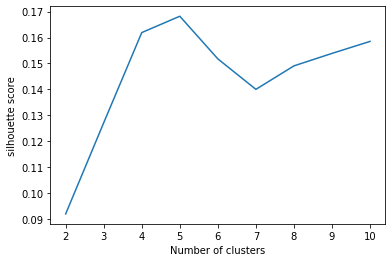

In [23]:
plt.plot(range(2,len(sh_score)),sh_score[2:])
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')

Από το διάγραμμα του shilhouette score βλέπουμε πως η τιμή του μεγιστοποιείται για αριθμό από clusters ίσο με 5.
Από το διάγραμμα του inertia-error ότι για αριθμό κέντρων μεγαλύτερο του 4, το σφάλμα πέφτει πολύ.
Συνδοιάζοντας την πληροφορία από τα 2 διαγράμματα θα έλεγε κανείς πως μια καλή τιμή για clustering ίσως να ήταν το 5.

### K-means για Κ=5

In [24]:
k=5
kmeans = sk_cluster.KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
kmeans.fit_predict(X)

array([2, 2, 0, 3, 2, 3, 3, 0, 1, 3, 3, 3, 3, 3, 0, 1, 2, 2, 3, 2, 2, 3,
       0, 1, 0, 0, 3, 1, 3, 2, 1, 3, 0, 4, 2, 0, 0, 4, 2, 3, 4, 3, 0, 1,
       2, 0, 0, 3, 2, 2, 3, 3, 1, 2, 3, 3, 2, 3, 3, 1, 3, 3, 4, 3, 1, 2,
       2, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3,
       2, 2, 2, 2, 1, 3, 2, 2, 3, 2, 3, 2, 3, 3, 1, 2, 3, 2, 1, 2, 3, 3,
       3, 3, 3, 1, 3, 0, 2, 0, 0, 3, 1, 3, 3, 2, 3, 2, 0, 2, 3, 0, 2, 3,
       4, 2, 3, 3, 0, 4, 3, 1, 1, 4, 2, 2, 0, 3, 2, 2, 2, 2, 1, 2, 2, 4,
       2, 1, 2, 2, 2, 3, 1, 1, 2, 2, 2, 2, 0, 2, 3, 1, 2, 3, 3, 0, 3, 2,
       2, 2, 1, 1, 3, 4, 2, 3, 2, 0, 0, 3, 0, 3, 3, 1, 3, 3, 0, 1, 3, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 1, 2, 3, 3, 2, 0,
       4, 3, 3, 2, 0, 0, 2, 3, 0, 0, 2, 1, 3, 0, 3, 3, 2, 2, 2, 2, 2, 3,
       2, 2, 0, 3, 2, 3, 3, 2, 2, 2, 2, 0, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2,
       1, 1, 3, 2, 3, 3, 0, 3, 0, 3, 4, 3, 2, 3, 1, 3, 3, 3, 4, 3, 1, 3,
       2, 2, 2, 3, 3, 3, 3, 2, 2, 4, 3, 3, 3, 0, 3,

In [25]:
mapped_kmeans_labels,C = cluster_class_mapping(kmeans.labels_,true_labels)
print(C)
scores(true_labels,mapped_kmeans_labels)

[[241   3  49]
 [  8 241   2]
 [ 12   1 192]]
[0.8225256  0.96015936 0.93658537]
[0.92337165 0.98367347 0.79012346]
0.9045506924092287
0.8998664886515354


#### Σχολιασμός αποτελέσματος για K-means με Κ=5 
* Ο k-means με 5 κέντρα δίνει καλύτερη κατηγοριοποίηση σε σύγκριση με αυτόν με 3. Ο λόγος είναι ότι μπορεί να έχουμε περισσότερα κέντρα αλλά αυτά τα κέντρα που είναι πιο όμοια μεταξύ τους κρατάνε μέσα στο cluster τους σημεία(επιχειρήσεις) που μπορεί να κέρδιζαν άλλα cluster λιγότερο σχετικά ως προς την κατηγορία του σημείου.

In [26]:
print("Top terms per cluster:")
asc_order_centroids = kmeans.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(k):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 hair
 cut
 haircut
 salon
 barber
 stylist
 great
 time
 appointment
 place
Cluster 1:
 nails
 nail
 shellac
 manicure
 pedicure
 polish
 salon
 pedi
 mani
 place
Cluster 2:
 food
 bar
 place
 good
 drinks
 great
 beer
 menu
 night
 like
Cluster 3:
 store
 service
 like
 just
 place
 great
 time
 staff
 customer
 shop
Cluster 4:
 massage
 spa
 facial
 skin
 room
 treatment
 place
 time
 relaxing
 like


In [27]:
print(kmeans.cluster_centers_)

[[0.00448594 0.01648837 0.00685435 ... 0.0102945  0.00576658 0.00043383]
 [0.00765064 0.02151299 0.00640749 ... 0.0066903  0.00371763 0.00055219]
 [0.00427834 0.02292442 0.00244007 ... 0.00433059 0.00636499 0.00896684]
 [0.00478382 0.0190339  0.01150149 ... 0.00692566 0.0078619  0.00074924]
 [0.00809307 0.0113503  0.01519439 ... 0.01190871 0.00428403 0.00059157]]


### Υπολογισμός των αποστάσεων μεταξύ των κέντρων

In [28]:
center_distances(kmeans)
print(kmeans.inertia_)

429.03420715047224


#### Ερώτηση 3 (2)
* Δεδομένου ότι το intertia είναι σχετικά μικρό για αριθμό clusters ίσο με 5 σημαίνει ότι υπάρχει σχετικά καλό coherency των σημείων μέσα στο κάθε cluster, σε συνδιασμό με αυτό η σχετικά μεγάλες αποστάσεις μεταξύ των κέντρων του κάθε cluster δίνει μια πιο λεπτομερή κατηγοριοποίηση μεταξύ των επιχειρήσεων η οποία κατηγοριοποίηση λαμβάνει υπόψιν της και επιμέρους διαφοροποιήσεις ανάμεσα σε επιχειρήσεις που μπορεί να ανήκουν στην ίδια κατηγορία αλλά ανήκουν και σε άλλες.